In [1]:
import sys
sys.path.append('../')

from abc import abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from raypy.utils.vector3 import vec3

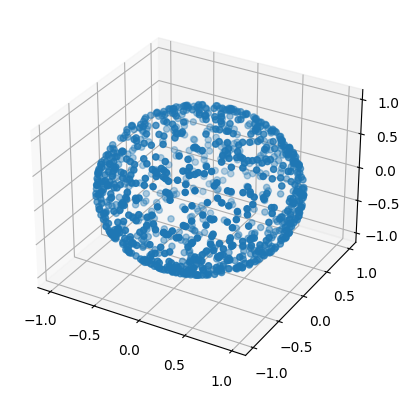

In [2]:
def random_in_unit_sphere(shape):
    #https://mathworld.wolfram.com/SpherePointPicking.html
    phi = np.random.rand(shape)*2*np.pi
    u = 2.*np.random.rand(shape) - 1.
    r = np.sqrt(1-u**2)
    return vec3( r*np.cos(phi),  r*np.sin(phi), u)

randoms = np.array([random_in_unit_sphere(1) for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

In [3]:
class PDF:
    """Probability density function"""
    @abstractmethod
    def value(self,ray_dir):
        """get probability density function value at direction ray_dir"""
        pass

    @abstractmethod
    def generate(self):
        """generate random ray  directions according the probability density function"""
        pass

In [4]:
class hemisphere_pdf(PDF):
    """Probability density Function"""
    def __init__(self,shape, normal):
        self.shape = shape
        self.normal = normal


    def value(self,ray_dir):
        return 1./(2.*np.pi)

    def generate(self):
        r = random_in_unit_sphere(self.shape)
        return vec3.where( self.normal.dot(r) < 0. , r*-1., r )

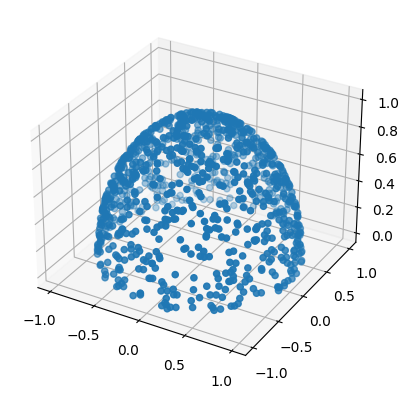

In [5]:
pdf = hemisphere_pdf(1, vec3(0,0,1))
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

In [29]:
class cosine_pdf(PDF):
    """Probability density Function"""
    def __init__(self,shape, normal):
        self.shape = shape
        self.normal = normal

    def value(self,ray_dir):
        return np.clip(ray_dir.dot(self.normal),0.,1.)/np.pi
        # for diffuse materials, the scattering PDF is cos(θ) / pi
        # which is the same as ray_dir.dot(normal) / pi

    def generate(self):
        ax_w = self.normal
        a = vec3.where(np.abs(ax_w.x) > 0.9, vec3(0, 1, 0), vec3(1, 0, 0))
        ax_v = ax_w.cross(a).normalize()
        ax_u = ax_w.cross(ax_v)
        # create basis

        phi = np.random.rand(self.shape) * 2 * np.pi
        theta = np.random.rand(self.shape) * 0.5 * np.pi

        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        return ax_u * x + ax_v * y + ax_w * z

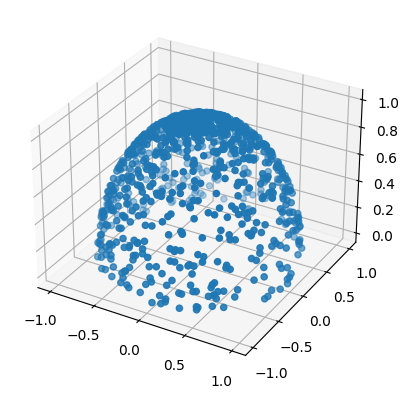

In [30]:
pdf = cosine_pdf(1, vec3(0,0,1))
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

In [8]:
class SphericalCapsPdf(PDF):
  """Probability density Function"""
  def __init__(self,shape, origin, importance_sampled_list):
      self.shape = shape
      self.origin = origin
      self.importance_sampled_list = importance_sampled_list
      self.l = len(importance_sampled_list)

  def value(self, ray_dir):
      PDF_value = 0.
      for i in range(self.l):
          PDF_value +=  np.where( ray_dir.dot(self.ax_w_list[i]) > self.cosθmax_list[i] , 1/((1 - self.cosθmax_list[i])*2*np.pi) , 0. )
      PDF_value = PDF_value/self.l
      return PDF_value


  def generate(self):
      shape = self.shape
      origin = self.origin
      importance_sampled_list = self.importance_sampled_list
      l = self.l

      mask = (np.random.rand(shape) * l).astype(int)
      mask_list = [None]*l

      cosθmax_list = [None]*l
      ax_u_list = [None]*l
      ax_v_list = [None]*l
      ax_w_list = [None]*l

      for i in range(l):

          ax_w_list[i] = (importance_sampled_list[i].center - origin).normalize()
          a = vec3.where( np.abs(ax_w_list[i].x) > 0.9 , vec3(0,1,0) , vec3(1,0,0))
          ax_v_list[i] = ax_w_list[i].cross(a).normalize()
          ax_u_list[i]  = ax_w_list[i].cross(ax_v_list[i])
          mask_list[i] = mask == i


          target_distance = np.sqrt((importance_sampled_list[i].center - origin).dot(importance_sampled_list[i].center - origin))

          cosθmax_list[i] = np.sqrt(1 - np.clip(importance_sampled_list[i].bounded_sphere_radius / target_distance, 0., 1.)**2 )

      self.cosθmax_list = cosθmax_list
      self.ax_w_list = ax_w_list

      phi = np.random.rand(shape)*2*np.pi
      r2 =  np.random.rand(shape)

      cosθmax = np.select(mask_list, cosθmax_list)
      ax_w =  vec3.select(mask_list, ax_w_list)
      ax_v =  vec3.select(mask_list, ax_v_list)
      ax_u =  vec3.select(mask_list, ax_u_list)

      z = 1. + r2 * (cosθmax - 1.)
      x = np.cos(phi) * np.sqrt(1. - z**2)
      y = np.sin(phi) * np.sqrt(1. - z**2)

      ray_dir = ax_u*x + ax_v*y + ax_w*z
      return ray_dir

Text(0.5, 0, 'Y axis')

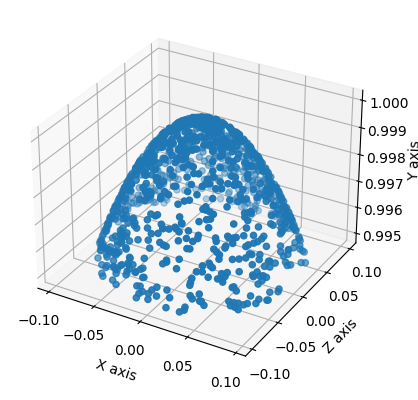

In [9]:
from raypy.geometry.sphere import Sphere

importance_sampled_list = [Sphere(center=vec3(0, 10, 0), material=None, radius=1)]

pdf = SphericalCapsPdf(1, vec3(0,0,0), importance_sampled_list)
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,-z,y)
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')

Text(0.5, 0, 'Y axis')

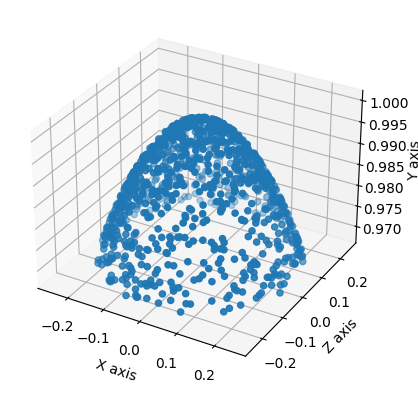

In [23]:
from raypy.geometry.sphere import Sphere

importance_sampled_list = [Sphere(center=vec3(0, 4, 0), material=None, radius=1)]

pdf = SphericalCapsPdf(1, vec3(0,0,0), importance_sampled_list)
randoms = np.array([pdf.generate() for _ in range(1000)])
x = np.array([i.x for i in randoms])
y = np.array([i.y for i in randoms])
z = np.array([i.z for i in randoms])
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(x,-z,y)
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')